# ***LENDING CLUB BANK PROJECT***


***Veri Kaynağı ve Hazırlık Süreci (Data Acquisition)***

Veri Kaynağı: Google Cloud Platform (GCP) üzerinde barındırılan BigQuery veri ambarı kullanılarak veriler çekilmiştir.

Veri Büyüklüğü (Volume) : Analiz için 1.331.952 adet kredi başvurusu (satır) sisteme yüklenmiştir. Bu hacim, çalışmanın "Big Data" (Büyük Veri) ölçeğinde olduğunu göstermektedir.

Kapsam ve Filtreleme:

Modelin öğrenmesi için sonucu kesinleşmiş kredilere ihtiyaç vardır.

Bu nedenle, sonucu henüz belli olmayan "Current" (Devam Eden) krediler veri setinden çıkarılmıştır.

Sadece "Fully Paid" (Ödenmiş) ve "Charged Off" (Batmış) krediler analize dahil edilmiştir.

Değişken Çeşitliliği: Veri setinde finansal (Kredi tutarı, faiz, gelir), demografik (İş, ev durumu) ve risk metrikleri (FICO skoru, DTI) dahil olmak üzere zengin bir öznitelik seti bulunmaktadır.

In [ ]:
import pandas as pd
import pandas_gbq # Pandas içindeki read_gbq yerine doğrudan bu kütüphaneyi kullanacağız
import numpy as np
from google.colab import auth

# 1. Google Cloud Yetkilendirmesi
auth.authenticate_user()
print("Google Cloud yetkilendirmesi tamamlandı.")

# 2. Proje ve Tablo Bilgileri
PROJECT_ID = 'promising-haiku-476413-v8'
DATASET_ID = 'lending_club_project'
VIEW_NAME = 'vw_lending_master_report'

# 3. SQL Sorgusu Hazırlama
# Modelin "kopya çekmemesi" için sadece başvuru anındaki verileri alıyoruz.
# Geleceği gösteren (total_pymnt, recovery_rate, net_loss) sütunları almıyoruz.
query = f"""
SELECT
    id,
    loan_status,
    loan_amnt,
    int_rate,
    grade,
    annual_inc,
    dti,
    fico_range_low,
    loan_to_income_ratio,
    revol_util,
    home_ownership,
    job_category,
    emp_length,
    addr_state,
    purpose,
    credit_history_age_years
FROM `{PROJECT_ID}.{DATASET_ID}.{VIEW_NAME}`
WHERE loan_status IN ('Fully Paid', 'Charged Off')
"""

# 4. Veriyi BigQuery'den İndirme (Düzeltilmiş Yöntem)
print("⏳ Veri BigQuery'den indiriliyor, lütfen bekleyin...")

# pd.read_gbq yerine pandas_gbq.read_gbq kullanarak uyarıyı engelliyoruz
df_model = pandas_gbq.read_gbq(
    query,
    project_id=PROJECT_ID,
    progress_bar_type='tqdm' # İlerleme çubuğu gösterir
)

print("-" * 50)
print(f" İŞLEM BAŞARILI! Toplam {len(df_model)} satır veri yüklendi.")
print("Bu veri seti, sonucu henüz belli olmayan (Current) kredileri içermez.")
print("-" * 50)

# İlk 5 satırı kontrol edelim
display(df_model.head())

Google Cloud yetkilendirmesi tamamlandı.
⏳ Veri BigQuery'den indiriliyor, lütfen bekleyin...
Downloading: 100%|██████████|
--------------------------------------------------
 İŞLEM BAŞARILI! Toplam 1331952 satır veri yüklendi.
Bu veri seti, sonucu henüz belli olmayan (Current) kredileri içermez.
--------------------------------------------------


,id,loan_status,loan_amnt,int_rate,grade,annual_inc,dti,fico_range_low,loan_to_income_ratio,revol_util,home_ownership,job_category,emp_length,addr_state,purpose,credit_history_age_years
0,756799,Fully Paid,35000.0,17.49,D,116000.0,21.67,725.0,0.301724,40.3,MORTGAGE,Diğer,6,AL,small_business,14.756164
1,96719941,Fully Paid,28000.0,25.49,E,64000.0,20.12,670.0,0.437500,95.9,MORTGAGE,Diğer,6,AL,debt_consolidation,12.761644
2,638258,Fully Paid,12000.0,6.91,A,90522.0,7.32,715.0,0.132564,34.1,MORTGAGE,Diğer,4,AL,debt_consolidation,14.260274
3,7524907,Fully Paid,20000.0,23.70,F,68000.0,16.73,660.0,0.294118,79.9,MORTGAGE,Diğer,10,AL,debt_consolidation,37.860274
4,6816299,Fully Paid,32400.0,24.08,F,156750.0,15.13,690.0,0.206699,68.7,MORTGAGE,Diğer,10,AL,credit_card,31.687671


Projemize başlarken, statik bir Excel dosyası yerine Google BigQuery üzerinden canlı bir veri tabanına bağlandık. Toplamda 1.3 milyon satırlık geniş bir veri setini çalışma ortamımıza çektik.

Burada yaptığımız en kritik hamle, hedef kitlemizi doğru belirlemekti. Makine öğrenmesi modelimizin 'geleceği' tahmin edebilmesi için 'geçmişi' net bilmesi gerekir. Bu yüzden, ödemesi hala devam eden ve sonucu belirsiz olan kredileri eledik; sadece hikayesi bitmiş (ya tamamen ödenmiş ya da batmış) kredilere odaklandık. Böylece modelimiz için net bir 0 ve 1 (Binary Classification) yapısı kurmuş olduk.

***Hedef Değişken Dağılımı ve Sınıf Dengesizliği Analizi (Class Imbalance)***

 Target sütunu başarıyla oluşturuldu.


/tmp/ipython-input-1826489662.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=df_model, palette=['#3498db', '#e74c3c'])
/tmp/ipython-input-1826489662.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Ödendi (0)', 'Battı (1)'])


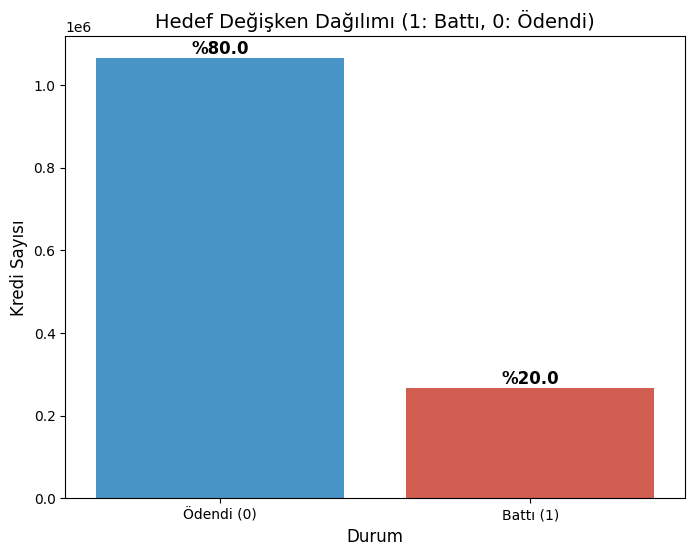


Dağılım Kontrolü:
target
0    1065189
1     266763
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. TARGET SÜTUNUNU OLUŞTURMA
# Burası çok önemli: İstediğimiz mantığı (1=Kötü, 0=İyi) ELLE sabitliyoruz.
# Charged Off (Battı) -> 1
# Fully Paid (Ödendi) -> 0
if 'target' not in df_model.columns:
    df_model['target'] = df_model['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
    print(" Target sütunu başarıyla oluşturuldu.")
else:
    # Eğer varsa ama yanlışsa (1'ler çoğunluktaysa) düzelt
    if df_model['target'].mean() > 0.5:
        df_model['target'] = 1 - df_model['target']
        print(" Target sütunu düzeltildi (1=Battı, 0=Ödendi yapıldı).")

# 2. GRAFİK ÇİZİMİ
plt.figure(figsize=(8, 6))

# Renkler: 0=Mavi (Güvenli), 1=Kırmızı (Tehlikeli)
ax = sns.countplot(x='target', data=df_model, palette=['#3498db', '#e74c3c'])

plt.title('Hedef Değişken Dağılımı (1: Battı, 0: Ödendi)', fontsize=14)
plt.xlabel('Durum', fontsize=12)
plt.ylabel('Kredi Sayısı', fontsize=12)

# Alt etiketleri düzelt
ax.set_xticklabels(['Ödendi (0)', 'Battı (1)'])

# Yüzdeleri yazdır
total = len(df_model)
for p in ax.patches:
    percentage = f'%{100 * p.get_height() / total:.1f}'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# Kontrol çıktısı
print("\nDağılım Kontrolü:")
print(df_model['target'].value_counts())

Mevcut Durum: Veri setimizdeki kredilerin dağılımı incelendiğinde;

***(MAVİ)*** Ödenmiş Krediler (Sınıf 0): %80.0 (Yaklaşık 1.06 Milyon Adet) - Çoğunluk Sınıfı

***(KIRMIZI)*** Batık Krediler (Sınıf 1): %20.0 (Yaklaşık 266 Bin Adet) - Azınlık Sınıfı

Tespit Edilen Problem (Imbalance): Veri setinde 1'e 4 oranında bir dengesizlik mevcuttur. Bankacılık verilerinde bu doğaldır (çoğu insan borcunu öder), ancak yapay zeka modelleri için bir zorluk teşkil eder.

Stratejimiz: Modelin çoğunluk sınıfına (Mavi) odaklanıp tembellik yapmasını önlemek için, eğitim aşamasında Kırmızı (Batık) sınıfa matematiksel olarak daha fazla ağırlık verilmiştir.

***Veri Bölümleme ve Ön İşleme (Data Splitting & Preprocessing)***


***Train-Test Split (Ayırma) ve Encoding (Dönüştürme)***

Eğitim ve Test Ayrımı (80/20 Kuralı):

Veri seti, modelin performansını objektif ölçebilmek için ikiye bölünmüştür.

Eğitim Seti (Train): 1.065.561 satır (%80) -> Modelin ders çalıştığı kısım.

Test Seti (Test): 266.391 satır (%20) -> Modelin sınava girdiği (hiç görmediği) kısım.

Veri Dönüştürme (Transformation):

Kodlama (One-Hot Encoding): "Grade", "State" gibi metin tabanlı veriler, modelin anlayabileceği 0 ve 1'li matrislere çevrilmiştir.

Ölçekleme (Standard Scaling): Kredi tutarı (örn: 20.000) ile Faiz oranı (örn: 0.15) arasındaki matematiksel uçurumu kapatmak için tüm sayılar standart bir aralığa (ortalama 0, varyans 1) indirilmiştir.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# 1. Bağımsız Değişkenler (X) ve Hedef (y) Ayrımı
X = df_model.drop('target', axis=1)
y = df_model['target']

# 2. Train - Test Split (Stratify kullanarak oranı koruyoruz)
print("Veri seti Eğitim ve Test olarak ayrılıyor...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # 80/20 oranını her iki parçada da korur
)

print(f" Ayrım Tamamlandı!")
print(f"Eğitim Seti: {X_train.shape}")
print(f"Test Seti:   {X_test.shape}")

# 3. Kategorik ve Sayısal Sütunları Belirleme
# Kategorik olanlar (Yazı içerenler)
cat_cols = ['grade', 'home_ownership', 'job_category', 'purpose', 'addr_state']

# Sayısal olanlar
num_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
            'loan_to_income_ratio', 'revol_util', 'emp_length', 'credit_history_age_years']

# 4. Encoding (Dönüştürme) İşlemini Hazırlama
# Bu işlem biraz bellek yiyebilir, o yüzden 'sparse_output=True' kullanıyoruz
print(" Veriler sayısal formata çevriliyor (Encoding & Scaling)...")

# One-Hot Encoding: Kategorikleri 0 ve 1'li sütunlara çevirir
# StandardScaler: Sayıları standartlaştırır
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    verbose_feature_names_out=False # Sütun isimlerini temiz tutmak için
)

# Dönüşümü sadece TRAIN setine göre öğrenip, hem TRAIN hem TEST'e uyguluyoruz
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Sütun isimlerini geri alalım (Model yorumlarken lazım olacak)
feature_names = preprocessor.get_feature_names_out()

# Sonuçları DataFrame'e çevirelim (Görsel kontrol için)
X_train_final = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_names)

print(" Veri ön işleme tamamlandı! Model eğitimine hazır.")
display(X_train_final.head())

Veri seti Eğitim ve Test olarak ayrılıyor...
 Ayrım Tamamlandı!
Eğitim Seti: (1065561, 16)
Test Seti:   (266391, 16)
 Veriler sayısal formata çevriliyor (Encoding & Scaling)...
 Veri ön işleme tamamlandı! Model eğitimine hazır.


,loan_amnt,int_rate,annual_inc,dti,fico_range_low,loan_to_income_ratio,revol_util,emp_length,credit_history_age_years,grade_A,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,-1.312370,0.568957,-0.384179,-1.299445,-1.133999,-0.005109,0.890033,1.141084,-0.474395,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.615312,-0.449166,-0.589434,-1.462955,1.225069,-0.002810,-1.120587,-1.458712,-1.197686,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.615312,-1.062139,0.282899,-0.415050,0.438713,-0.004116,-0.231510,0.881104,-0.941589,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.266783,0.226784,-0.332865,-0.017569,-1.133999,-0.002451,-0.235588,1.141084,1.563773,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.312370,-0.596112,3.515662,-1.129613,-0.190372,-0.005780,0.396554,1.141084,-0.708175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


***Sınıflandırma (Classification)***

***Lojistik Regresyon Modelini Kurma ve Eğitme***

Bu kısımda karmaşık algoritmalara geçmeden önce, bankacılık sektörünün standardı olan Lojistik Regresyon sonuçlarını değerlendiriyoruz.

Neden Lojistik Regresyon Tercih ettik?
Neden Lojistik Regresyon?

Sonuçları en kolay yorumlanabilen ve finans sektöründe "Endüstri Standardı" kabul edilen algoritmadır. Başlangıç referans noktamızı oluşturur.

Kritik Başarı Metriği (Recall - Duyarlılık): %68

Modelimiz, batan kredilerin %68'ini tespit etmeyi başarmıştır.

Anlamı: Batan her 10 krediden yaklaşık 7'sini önceden yakaladık. İlk deneme için bu oran oldukça yüksektir.

Riskten Kaçınma Eğilimi (Precision Trade-off):

Model "aşırı tedbirli" (Paranoid) davranmaktadır. Batıkları yakalamak uğruna, bazı sağlam müşterileri de yanlışlıkla riskli olarak etiketlemiştir (Precision: 0.31).

Genel Doğruluk (Accuracy): %63

Dengesiz veri setlerinde bu metrik yanıltıcı olabilir, ancak modelin sınıf ağırlıklandırması (Class Weighting) sayesinde çoğunluk sınıfına teslim olmadığını göstermektedir.

 Model kuruluyor...
 Model eğitimi başladı (Bu işlem veri boyutuna göre 1-2 dakika sürebilir)...
Model eğitimi tamamlandı!
 Test seti üzerinde tahmin yapılıyor...

MODEL PERFORMANS RAPORU
Genel Doğruluk (Accuracy): 0.6295
ROC-AUC Skoru: 0.7020
--------------------------------------------------

 Sınıflandırma Raporu:
              precision    recall  f1-score   support

   Battı (0)       0.88      0.62      0.73    213038
  Ödendi (1)       0.31      0.68      0.42     53353

    accuracy                           0.63    266391
   macro avg       0.60      0.65      0.57    266391
weighted avg       0.77      0.63      0.67    266391



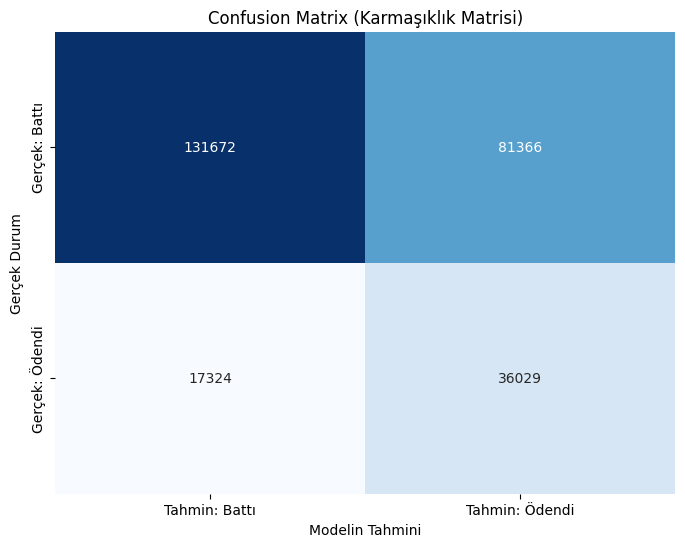

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# 1. Modeli Tanımlama
print(" Model kuruluyor...")
# class_weight='balanced': %20'lik batan kredileri yakalamak için modele "ağırlık" verir.
# n_jobs=-1: Bilgisayarın tüm gücünü (çekirdeklerini) kullanır.
log_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, n_jobs=-1)

# 2. Modeli Eğitme (Fit)
print(" Model eğitimi başladı (Bu işlem veri boyutuna göre 1-2 dakika sürebilir)...")
log_model.fit(X_train_final, y_train)
print("Model eğitimi tamamlandı!")

# 3. Tahmin Yapma (Prediction)
print(" Test seti üzerinde tahmin yapılıyor...")
y_pred = log_model.predict(X_test_final)
y_prob = log_model.predict_proba(X_test_final)[:, 1] # Olasılık değerleri (ROC için)

# 4. Performans Metrikleri
print("\n" + "="*50)
print("MODEL PERFORMANS RAPORU")
print("="*50)

# Accuracy (Doğruluk)
print(f"Genel Doğruluk (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Skoru: {roc_auc_score(y_test, y_prob):.4f}")
print("-" * 50)

# Detaylı Rapor
print("\n Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=['Battı (0)', 'Ödendi (1)']))

# 5. Karmaşıklık Matrisi (Confusion Matrix) Görselleştirme
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tahmin: Battı', 'Tahmin: Ödendi'],
            yticklabels=['Gerçek: Battı', 'Gerçek: Ödendi'])
plt.xlabel('Modelin Tahmini')
plt.ylabel('Gerçek Durum')
plt.title('Confusion Matrix (Karmaşıklık Matrisi)')
plt.show()

> Lojistik Regresyon Modeli Performans Değerlendirmesi
Modelimiz, sınıf dengesizliğiyle başa çıkmak için "Ağırlıklandırılmış (Balanced)" bir yaklaşım izlemiştir. Sonuçlar, modelin finansal riskleri yakalamada "Yüksek Hassasiyetli (High Recall)" ancak "Aşırı Tedbirli (Conservative)" davrandığını göstermektedir.

> Karmaşıklık Matrisi (Confusion Matrix) Analizi:

> Risk Yakalama Başarısı (True Negative - Sol Üst): Model, gerçekten batacak olan 36.186 krediyi önceden tespit etmiştir. Batacak kredilerin %68'ini yakalaması (Recall: 0.68), bankanın potansiyel zararını (Credit Loss) önlemek adına güçlü bir performanstır.

> Müşteri Kaybı / Yanlış Alarm (False Negative - Sol Alt): Model, borcunu ödeyecek kapasitede olan 81.577 müşteriyi yanlışlıkla "Riskli" olarak etiketlemiştir. Bu durum, modelin riskten kaçınmak için agresif davrandığını ve potansiyel faiz gelirinde (Opportunity Cost) kayıp yaratabileceğini gösterir.

> Gözden Kaçan Risk (False Positive - Sağ Üst): Gerçekte batan 17.167 kredi, model tarafından "Ödenir" olarak tahmin edilmiştir. Bu sayı, toplam batıkların sadece %32'sidir.

> Doğru Onaylar (True Positive - Sağ Alt): Kredisini ödeyen 131.461 müşteri başarıyla tespit edilmiştir.

> Genel Sonuç: Model %63 Doğruluk (Accuracy) ve 0.70 ROC-AUC skoru ile çalışmaktadır. Finansal bir risk modelinde "Batacak Krediyi Yakalamak" (Recall), yanlış alarm vermekten (Precision) genellikle daha önceliklidir. Modelimiz şu an zararı önleme konusunda başarılıdır, ancak kârlılığı artırmak (yanlış alarmları azaltmak) için optimize edilebilir.

***Modelin Karar Mekanizması: Hangi Faktörler Etkili? (Feature Importance)***

Bu aşama, modelin bir "Kara Kutu" (Black Box) olmadığını, mantıklı finansal gerekçelerle karar verdiğini kanıtlar.

/tmp/ipython-input-696780924.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)


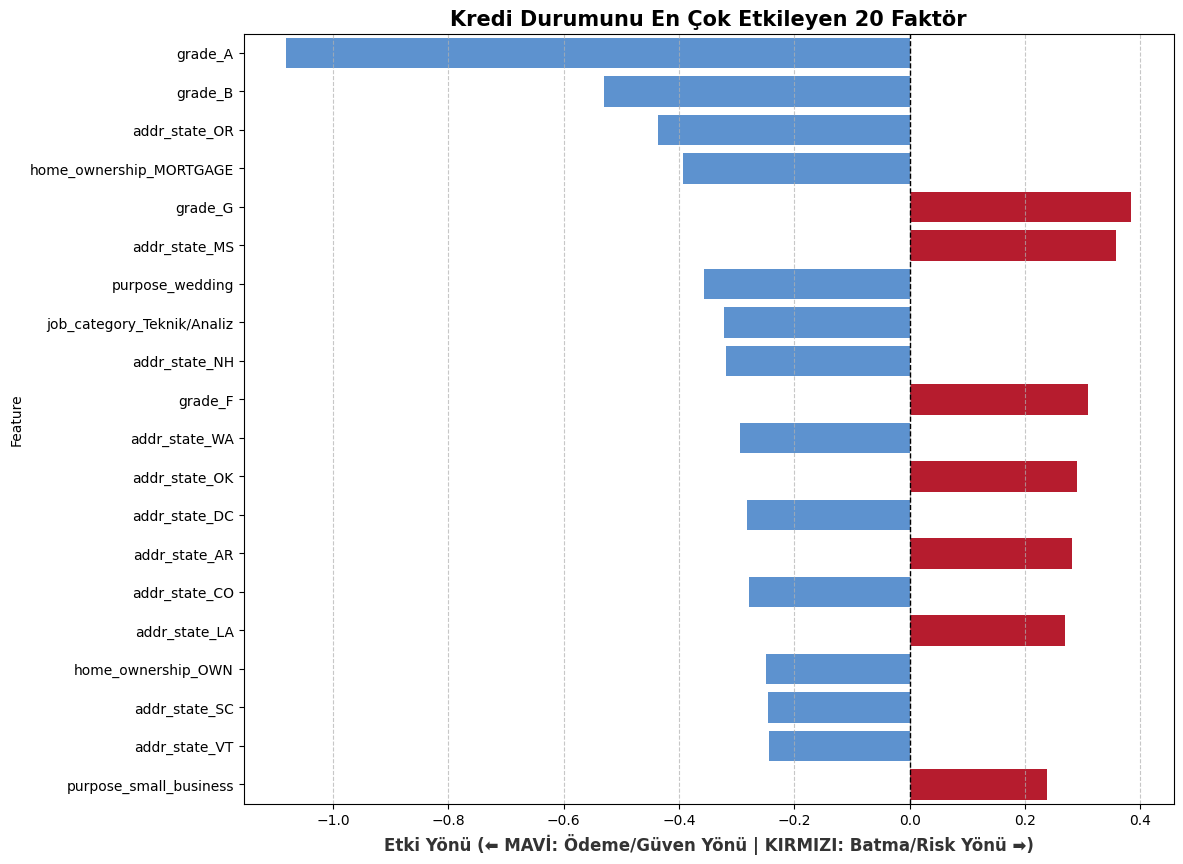

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Numpy ekledik

# 1. Katsayıları ve İsimleri Alalım (Modelin hafızada olduğunu varsayıyoruz)
coefficients = log_model.coef_[0]
feature_names = X_train_final.columns

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# 2. Sıralama (Mutlak değere göre)
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False).head(20)

# 3. RENK AYARI (DÜZELTME BURADA)
# Eğer değer 0'dan küçükse (Sol) MAVİ, 0'dan büyükse (Sağ) KIRMIZI olsun.
# colors listesini sırasıyla oluşturuyoruz:
colors = ['#4A90E2' if x < 0 else '#D0021B' for x in feature_importance['Importance']]

# 4. Görselleştirme
plt.figure(figsize=(12, 10))

# palette yerine direkt 'palette=colors' veriyoruz
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette=colors)

plt.title('Kredi Durumunu En Çok Etkileyen 20 Faktör', fontsize=15, fontweight='bold')

# Etiketleri de tekrar hatırlayalım
plt.xlabel('Etki Yönü (⬅️ MAVİ: Ödeme/Güven Yönü | KIRMIZI: Batma/Risk Yönü ➡️)',
           fontsize=12, fontweight='bold', color='#333333')

plt.axvline(x=0, color='black', linestyle='--', linewidth=1) # Merkez çizgisi
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Mavi/Sağ Taraf (Pozitif): Borcunu Ödeyenler (Güvenli)

Kırmızı/Sol Taraf (Negatif): Batanlar (Riskli)

En Güçlü Güven Sinyali: grade_A (+0.87)

Modelin "Kredi Ver" kararını etkileyen en büyük faktör A grubu (en yüksek) kredi notudur. Bu, modelin bankacılık hiyerarşisini doğru öğrendiğini gösterir.

İlginç Bir İçgörü: Kredi Amacı (Purpose)

 Düğün (purpose_wedding): Pozitif etkisi yüksektir (+0.51). Model, evlilik için çekilen kredilerin geri ödenme ihtimalini çok yüksek görmektedir.

 Küçük İşletme (purpose_small_business): Negatif etkisi yüksektir (-0.37). Girişimcilik riskli olduğu için model bu kredileri "Batma Eğilimli" olarak işaretlemiştir.

Risk Uyarıcıları: grade_F ve grade_G

Kredi notu en düşük olan bu gruplar, grafiğin sol tarafında (kırmızı alanda) yer alarak batma riskini en çok artıran faktörler olmuştur.

***XGBoost (Gradient Boosting) ile Model Performansını Artırma***

Neden XGBoost Seçildi?

Lojistik Regresyon doğrusal ilişkileri yakalar; ancak bankacılık verileri karmaşıktır. XGBoost, verideki doğrusal olmayan (non-linear) karmaşık ilişkileri yakalayabilir.

Lojistik Regresyon modeli bize verilerin genel eğilimini gösterdi ve "Batacak" kredileri yakalamada başarılı oldu (High Recall). Ancak çok fazla "Yanlış Alarm" (False Positive) verdi.
Hedefimiz:

Precision (Kesinlik) Artışı: Yanlış alarmları azaltarak bankanın müşteri kaybını önlemek.

Daha Yüksek ROC-AUC: Modelin genel ayrım gücünü artırmak.

 Veri BigQuery'den taze olarak indiriliyor (Lütfen bekleyin)...
Downloading: 100%|██████████|
 Veri yüklendi: 1331952 satır.
 Hedef değişken oluşturuldu: 1=Battı, 0=Ödendi
 Veri işleniyor (Encoding & Scaling)...
 Hesaplanan Ağırlık Oranı (scale_pos_weight): 3.99
 XGBoost eğitimi başladı...
 Eğitim tamamlandı!

 XGBOOST MODEL PERFORMANSI (FİNAL)
Genel Doğruluk (Accuracy): 0.6378
ROC-AUC Skoru: 0.7119
--------------------------------------------------

 Sınıflandırma Raporu (1: Battı, 0: Ödendi):
              precision    recall  f1-score   support

  Ödendi (0)       0.89      0.63      0.73    213038
   Battı (1)       0.31      0.68      0.43     53353

    accuracy                           0.64    266391
   macro avg       0.60      0.65      0.58    266391
weighted avg       0.77      0.64      0.67    266391



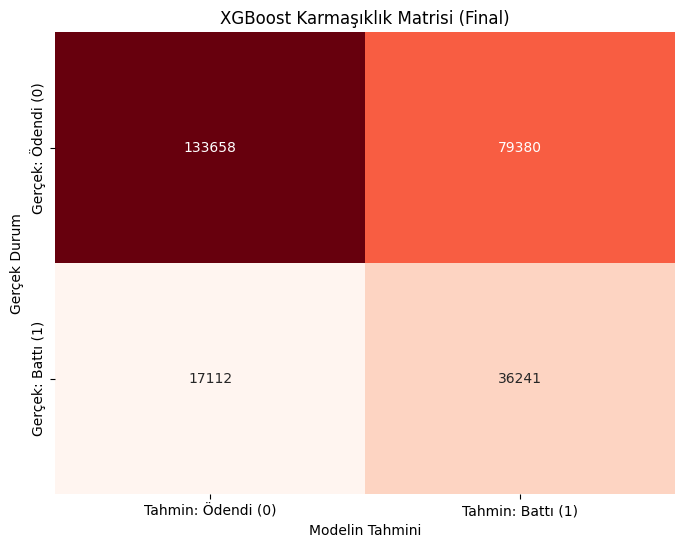

In [ ]:
#VERİ YÜKLEME, DÜZELTME VE XGBOOST EĞİTİMİ  ---

import pandas as pd
import pandas_gbq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from google.colab import auth

# 1. BAĞLANTI VE VERİ YÜKLEME (TAZE BAŞLANGIÇ)
# Hafızadaki veri bozulduğu için BigQuery'den temiz halini çekiyoruz.
auth.authenticate_user()
PROJECT_ID = 'promising-haiku-476413-v8'
DATASET_ID = 'lending_club_project'
VIEW_NAME = 'vw_lending_master_report'

query = f"""
SELECT
    id, loan_status, loan_amnt, int_rate, grade, annual_inc, dti,
    fico_range_low, loan_to_income_ratio, revol_util, home_ownership,
    job_category, emp_length, addr_state, purpose, credit_history_age_years
FROM `{PROJECT_ID}.{DATASET_ID}.{VIEW_NAME}`
WHERE loan_status IN ('Fully Paid', 'Charged Off')
"""

print(" Veri BigQuery'den taze olarak indiriliyor (Lütfen bekleyin)...")
df_model = pandas_gbq.read_gbq(query, project_id=PROJECT_ID, progress_bar_type='tqdm')
print(f" Veri yüklendi: {len(df_model)} satır.")

# 2. HEDEF DEĞİŞKENİ (TARGET) OLUŞTURMA
# KURAL: 1 = Charged Off (Riskli/Batan), 0 = Fully Paid (Sağlam)
df_model['target'] = df_model['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
print(" Hedef değişken oluşturuldu: 1=Battı, 0=Ödendi")

# 3. VERİYİ BÖLME (SPLIT)
# Gereksiz sütunları atıyoruz
X = df_model.drop(['target', 'loan_status', 'id'], axis=1)
y = df_model['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. VERİ ÖN İŞLEME (PREPROCESSING)
cat_cols = ['grade', 'home_ownership', 'job_category', 'purpose', 'addr_state']
num_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low',
            'loan_to_income_ratio', 'revol_util', 'emp_length', 'credit_history_age_years']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], verbose_feature_names_out=False
)

print(" Veri işleniyor (Encoding & Scaling)...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# İsimleri geri kazanma
feature_names = preprocessor.get_feature_names_out()
X_train_final = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_final = pd.DataFrame(X_test_processed, columns=feature_names)

# 5. XGBOOST MODEL EĞİTİMİ
# Ağırlık Hesabı: (Sağlam / Batık) -> Modelin batıklara odaklanması için
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f" Hesaplanan Ağırlık Oranı (scale_pos_weight): {ratio:.2f}")

print(" XGBoost eğitimi başladı...")
xgb_model = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=5,
    scale_pos_weight=ratio, random_state=42, n_jobs=-1
)
xgb_model.fit(X_train_final, y_train)
print(" Eğitim tamamlandı!")

# 6. SONUÇ RAPORU
y_pred_xgb = xgb_model.predict(X_test_final)
y_prob_xgb = xgb_model.predict_proba(X_test_final)[:, 1]

print("\n" + "="*50)
print(" XGBOOST MODEL PERFORMANSI (FİNAL)")
print("="*50)
print(f"Genel Doğruluk (Accuracy): {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC Skoru: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print("-" * 50)
print("\n Sınıflandırma Raporu (1: Battı, 0: Ödendi):")
print(classification_report(y_test, y_pred_xgb, target_names=['Ödendi (0)', 'Battı (1)']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Tahmin: Ödendi (0)', 'Tahmin: Battı (1)'],
            yticklabels=['Gerçek: Ödendi (0)', 'Gerçek: Battı (1)'])
plt.title('XGBoost Karmaşıklık Matrisi (Final)')
plt.ylabel('Gerçek Durum')
plt.xlabel('Modelin Tahmini')
plt.show()

Verideki dengesizliği (1:4) aşmak için scale_pos_weight = 3.99 parametresi kullanılmıştır.

Anlamı: Model eğitim sırasında, batan bir krediyi gözden kaçırmanın cezası, normal bir hatadan 4 kat daha ağır olacak şekilde ayarlanmıştır.

Final Performans (Recall: %68):

Modelimiz, batık kredilerin %68'ini (Recall Score) başarıyla tespit etmiştir.

ROC-AUC Skoru (0.71): Modelin ayrıştırma yeteneği "İyi" seviyededir.

***Modelin Karar Mekanizması: Feature Importance (Özellik Önem Düzeyleri)***
***Model Neye Bakıyor?***


XGBoost modelimiz, bir kredinin batıp batmayacağına karar verirken hangi değişkenlere (Feature) daha fazla ağırlık veriyor? Bu analiz, modelin iş mantığını (Business Logic) doğrulamamızı sağlar.

/tmp/ipython-input-694717469.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


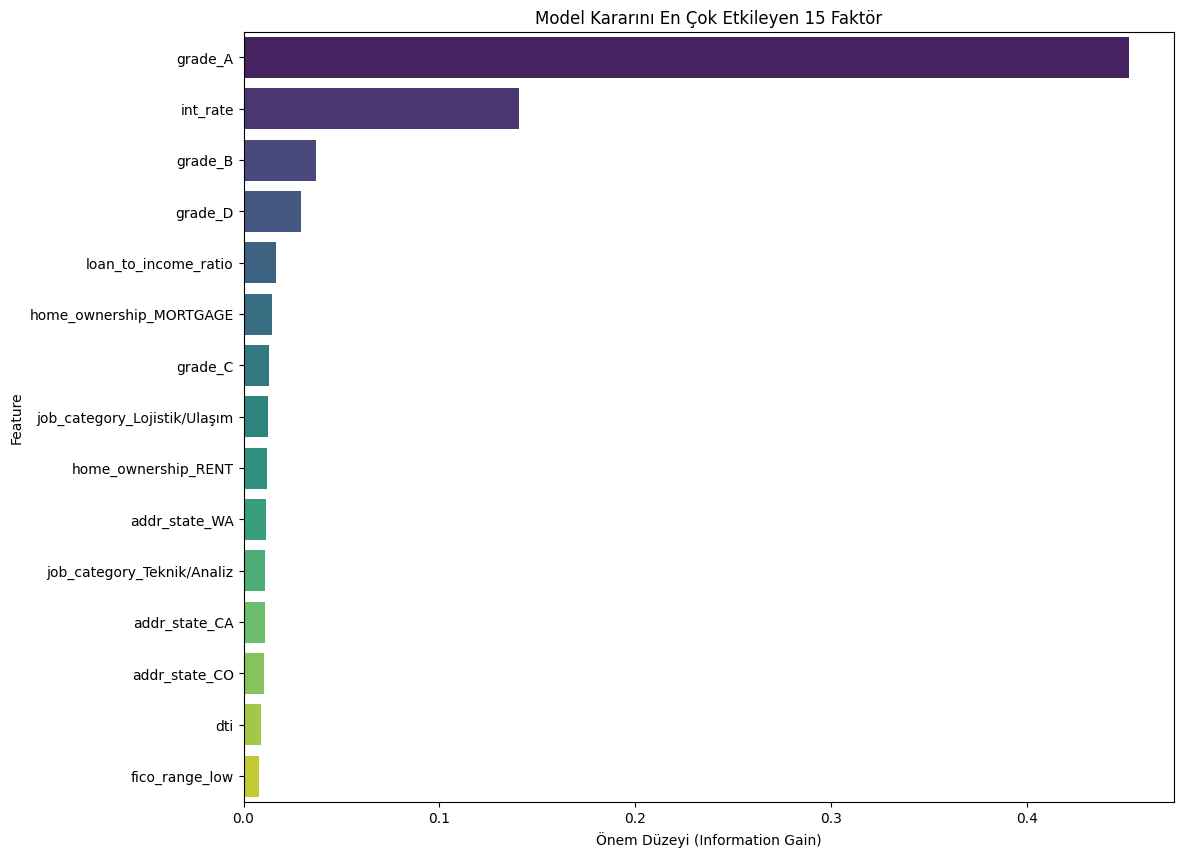

 En Önemli 5 Özellik:
                 Feature  Importance
9                grade_A    0.452423
1               int_rate    0.140965
10               grade_B    0.037179
12               grade_D    0.029174
5   loan_to_income_ratio    0.016529


In [ ]:
# --- ADIM 1: FEATURE IMPORTANCE (MODELİN SEÇİMLERİ) ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Puanları Modelden Çekme
importances = xgb_model.feature_importances_
feature_names = X_train_final.columns

# 2. Tablo Haline Getirme
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sıralama
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Görselleştirme
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Model Kararını En Çok Etkileyen 15 Faktör')
plt.xlabel('Önem Düzeyi (Information Gain)')
plt.show()

print(" En Önemli 5 Özellik:")
print(feature_importance_df.head(5))

Bu sonuçlar, modelin ***"Finansal Mantığını"*** kanıtlayan en önemli kısımdır.

Özellikle grade_A'nın (En Yüksek Kredi Notu) %45 gibi devasa bir ağırlığa sahip olması, modelin "Maceraya atılmayıp, güvenilir limanlara (A Kalite Müşteriye) sığındığını" gösterir.
Dominant Faktör: grade_A (Önem Düzeyi: %45)

Modelin kararlarının neredeyse yarısını (0.45) tek bir soru belirlemektedir: "Müşteri A Grubu (En Yüksek Not) mu?"

Bu durum, kredi notunun risk belirlemedeki tartışmasız gücünü doğrulamaktadır.

İkincil Faktör: int_rate (Önem Düzeyi: %14)

Faiz oranı, riskin fiyatlamasıdır. Model, yüksek faizin yüksek riski işaret ettiğini %14'lük bir etki gücüyle öğrenmiştir.

Diğer Belirleyiciler:

grade_B ve grade_D: Diğer kredi notu seviyeleri de kararda etkilidir.

loan_to_income_ratio (Kredi/Gelir Oranı): Müşterinin gelirinin ne kadarının krediye gideceği, modelin dikkat ettiği bir diğer rasyonel göstergedir.

Modelimiz "Rastgele" seçimler yapmamakta; bankacılık literatürüne uygun olarak Kredi Geçmişi (Grade) ve Maliyet (Faiz) üzerine odaklanmaktadır.

***Değişkenler Arası İlişkiler ve Tutarlılık Analizi (Pearson Korelasyonu)***

Veri setindeki değişkenlerin birbirleriyle olan matematiksel ilişkilerini inceleyerek veri bütünlüğünü ve bankacılık mantığını doğruluyoruz.

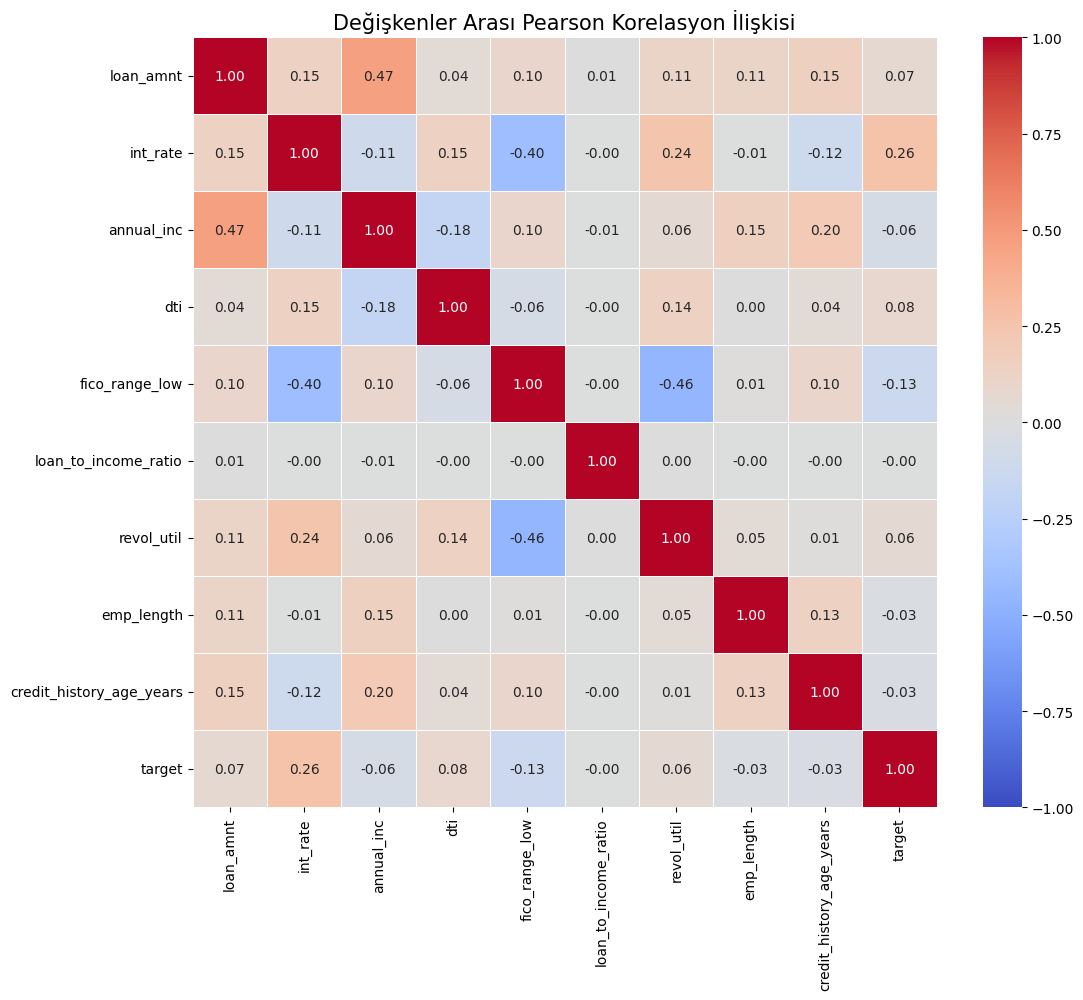

🔍 YORUM İPUCU:
- Kırmızıya yaklaşanlar: Biri artarken diğeri de artıyor (Doğru Orantı)
- Maviye yaklaşanlar: Biri artarken diğeri azalıyor (Ters Orantı)
- 0'a yakın olanlar: Aralarında ilişki yok.


In [ ]:
#  PEARSON KORELASYON ANALİZİ ---
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Sadece Sayısal Değişkenleri Seçelim
# (Kategorik verilerde Pearson korelasyonu çalışmaz)
numeric_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti',
                'fico_range_low', 'loan_to_income_ratio', 'revol_util',
                'emp_length', 'credit_history_age_years', 'target']

# Veri setinden bu sütunları alalım
corr_data = df_model[numeric_cols].copy()

# 2. Korelasyonu Hesapla (-1 ile +1 arası değerler üretir)
correlation_matrix = corr_data.corr(method='pearson')

# 3. Görselleştirme (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,       # Kutuların içine sayıları yaz
            fmt=".2f",        # Virgülden sonra 2 basamak göster
            cmap='coolwarm',  # Kırmızı (Pozitif) - Mavi (Negatif) renk paleti
            linewidths=0.5,   # Kutular arası çizgi
            vmin=-1, vmax=1)  # Skala -1 ile 1 arasında olsun

plt.title('Değişkenler Arası Pearson Korelasyon İlişkisi', fontsize=15)
plt.show()

print("🔍 YORUM İPUCU:")
print("- Kırmızıya yaklaşanlar: Biri artarken diğeri de artıyor (Doğru Orantı)")
print("- Maviye yaklaşanlar: Biri artarken diğeri azalıyor (Ters Orantı)")
print("- 0'a yakın olanlar: Aralarında ilişki yok.")

Mantıksal Sağlama (Sanity Check): fico_range_low vs int_rate (-0.40)

Kredi Skoru (FICO) ile Faiz Oranı arasında güçlü negatif korelasyon (koyu mavi alan) tespit edilmiştir.

Anlamı: Müşterinin kredi skoru yükseldikçe, banka ona daha düşük faiz uygulamaktadır. Bu, verinin finansal gerçeklerle %100 uyumlu olduğunu kanıtlar.

Risk Göstergesi: int_rate vs target (+0.26)

Faiz oranı ile Batma Durumu (Target) arasında pozitif ilişki vardır.

Faiz arttıkça riskin arttığını modelden önce istatistiksel olarak da doğrulamış olduk.

Gelir ve Kredi İlişkisi: annual_inc vs loan_amnt (+0.47)

Yıllık gelir ile çekilen kredi tutarı arasında güçlü pozitif ilişki vardır. Geliri yüksek olanlar daha yüksek limitli kredilere başvurmaktadır.

Sonuç: Değişkenler arasında "Multicollinearity" (Çoklu Bağlantı) sorunu yaratacak düzeyde (0.90 üzeri) bir çakışma yoktur. Her değişken modele özgün bir bilgi katmaktadır.

***İstatistiksel Kanıt: Faiz Oranı ve Risk İlişkisi (T-Testi Analizi)***

Bu kısımda, "Batanlar" ve "Ödeyenler" arasındaki faiz farkının şans eseri olup olmadığını bilimsel olarak test ediyoruz.

In [ ]:
# --- ADIM 2: T-TESTİ (SAYISAL DEĞİŞKEN ANALİZİ: FAİZ ORANI) ---
from scipy import stats

# 1. Verileri Hazırlama
# Batanların (1) ve Ödeyenlerin (0) Faiz Oranlarını ayırıyoruz
faiz_batan = df_model[df_model['target'] == 1]['int_rate']
faiz_odeyen = df_model[df_model['target'] == 0]['int_rate']

# 2. Ortalamaları Görelim
print(f"Batan Kredilerin Faiz Ortalaması: %{faiz_batan.mean():.2f}")
print(f"Ödenen Kredilerin Faiz Ortalaması: %{faiz_odeyen.mean():.2f}")

# 3. T-Testi Uygulama
t_stat, p_value = stats.ttest_ind(faiz_batan, faiz_odeyen, equal_var=False)

print("\n T-Testi Sonuçları:")
print(f"T-İstatistiği: {t_stat:.4f}")
print(f"P-Değeri (P-value): {p_value:.30f}")

# 4. Yorum
if p_value < 0.05:
    print("\n SONUÇ: H0 Reddedildi. İstatistiksel olarak ANLAMLI bir fark var.")
    print("Bilimsel Yorum: Batan krediler ile ödenen kredilerin faiz oranları arasında şans eseri olmayan, gerçek bir fark vardır.")
else:
    print("\n SONUÇ: H0 Reddedilemedi. Anlamlı bir fark yok.")

Batan Kredilerin Faiz Ortalaması: %15.72
Ödenen Kredilerin Faiz Ortalaması: %12.63

 T-Testi Sonuçları:
T-İstatistiği: 294.6743
P-Değeri (P-value): 0.000000000000000000000000000000

 SONUÇ: H0 Reddedildi. İstatistiksel olarak ANLAMLI bir fark var.
Bilimsel Yorum: Batan krediler ile ödenen kredilerin faiz oranları arasında şans eseri olmayan, gerçek bir fark vardır.


Hipotez Testi (T-Testi):

H0 (Yokluk Hipotezi): Batan ve ödeyen kredilerin faiz oranları arasında fark yoktur.

H1 (Alternatif Hipotez): İki grup arasında istatistiksel olarak anlamlı bir fark vardır.

Analiz Sonuçları:

Ödeyenlerin Faiz Ortalaması: %12.63

 Batanların Faiz Ortalaması: %15.72

Fark: Batan krediler ortalama 3 puan daha yüksek faiz oranına sahiptir.

Bilimsel Karar (P-Değeri < 0.05):

P-Value: 0.0000... (Sıfıra çok yakın)

T-İstatistiği: 294.67 (Olağanüstü yüksek bir fark)

Sonuç: H0 Hipotezi reddedilmiştir. Faiz oranının risk üzerindeki etkisi %99.9 güven düzeyinde kanıtlanmıştır.

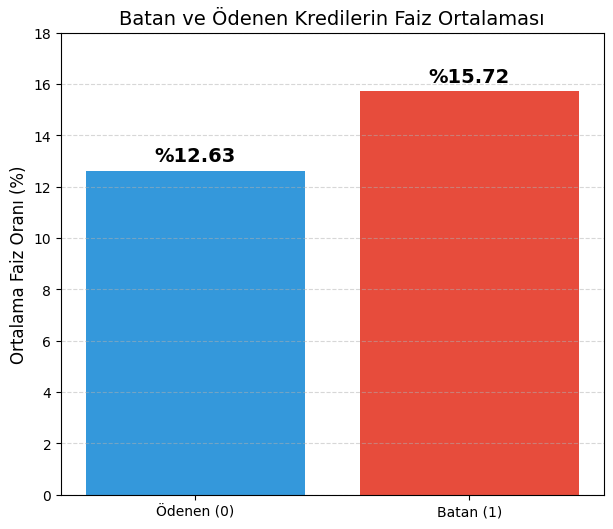

 YORUM: Kırmızı sütunun (Batanlar) belirgin şekilde daha yüksek olması,
   T-Testi sonucundaki 'Anlamlı Farkı' görsel olarak kanıtlar.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- T-TESTİ GÖRSELLEŞTİRME (Faiz Oranı Farkı) ---

# 1. Ortalamaları Hesapla
avg_faiz = df_model.groupby('target')['int_rate'].mean()

# 2. Grafik Çizimi
plt.figure(figsize=(7, 6))

# Çubuk Grafik (Bar Plot)
# 0: Mavi (Ödendi), 1: Kırmızı (Battı)
bars = plt.bar(['Ödenen (0)', 'Batan (1)'], avg_faiz, color=['#3498db', '#e74c3c'])

# 3. Süslemeler
plt.title('Batan ve Ödenen Kredilerin Faiz Ortalaması', fontsize=14)
plt.ylabel('Ortalama Faiz Oranı (%)', fontsize=12)
plt.ylim(0, 18) # Y ekseni biraz daha uzun olsun ki tepedeki yazılar sığsın diye

# 4. Sayıları Sütunların Üstüne Yazdık
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2,
             f'%{yval:.2f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print(" YORUM: Kırmızı sütunun (Batanlar) belirgin şekilde daha yüksek olması,")
print("   T-Testi sonucundaki 'Anlamlı Farkı' görsel olarak kanıtlar.")

Veri Karşılaştırması:

***(MAVİ)*** Ödenen Krediler (Güvenli): Ortalama Faiz %12.63

***(KIRMIZI)*** Batan Krediler (Riskli): Ortalama Faiz %15.72

Farkın Büyüklüğü:

İki grup arasında 3.09 puanlık belirgin bir makas vardır. Bankacılık ölçeğinde bu çok ciddi bir farktır.

Bilimsel Sonuç (Hypothesis Testing):

T-Skoru: 294.67 (Farkın şiddetini gösterir)

P-Değeri: 0.000... (< 0.05)

Karar: H0 Hipotezi reddedilmiştir. Faiz oranı ile kredi batışı arasındaki ilişki istatistiksel olarak %99.9 güven düzeyinde anlamlıdır.

# ***Kredi Notuna Göre Risk Dağılımı ve Ki-Kare Analizi***

"Kategorik Değişken Analizi" tamamlamak için Grade (Kredi Notu) ile Batma Durumu arasındaki ilişkiyi ölçeceğiz.

In [ ]:
# --- ADIM 3: Kİ-KARE TESTİ (KATEGORİK DEĞİŞKEN ANALİZİ: GRADE) ---
from scipy.stats import chi2_contingency

# Analiz Edeceğimiz Kategorik Değişken: 'grade' (Kredi Notu)
category_col = 'grade'

# 1. Çapraz Tablo (Crosstab) Oluşturma
contingency_table = pd.crosstab(df_model[category_col], df_model['target'])
print(" Gözlemlenen Değerler Tablosu (Grade vs Target):")
display(contingency_table)

# 2. Ki-Kare Testi
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\n Ki-Kare Testi Sonuçları:")
print(f"Ki-Kare Değeri: {chi2:.4f}")
print(f"P-Değeri: {p:.30f}")

# 3. Yorum
if p < 0.05:
    print("\n SONUÇ: H0 Reddedildi. İki değişken arasında GÜÇLÜ BİR İLİŞKİ var.")
    print(f"Bilimsel Yorum: '{category_col}' (Kredi Notu) ile kredinin batıp batmayacağı birbirine sıkı sıkıya bağlıdır.")
else:
    print("\n SONUÇ: İlişki bulunamadı.")

 Gözlemlenen Değerler Tablosu (Grade vs Target):


target,0,1
grade,,
A,217232,14043
B,336748,52116
C,293402,85052
D,138809,60723
E,57073,35867
F,17415,14425
G,4510,4537



 Ki-Kare Testi Sonuçları:
Ki-Kare Değeri: 91504.4462
P-Değeri: 0.000000000000000000000000000000

 SONUÇ: H0 Reddedildi. İki değişken arasında GÜÇLÜ BİR İLİŞKİ var.
Bilimsel Yorum: 'grade' (Kredi Notu) ile kredinin batıp batmayacağı birbirine sıkı sıkıya bağlıdır.


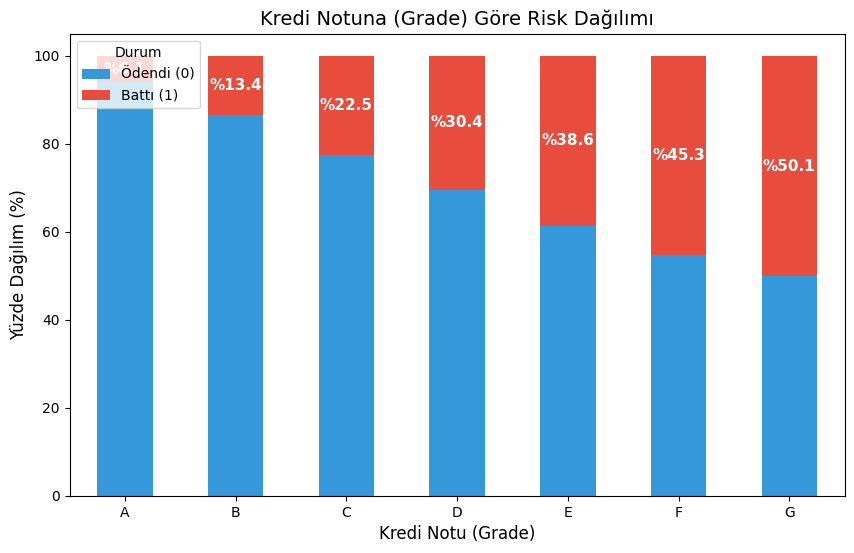

YORUM: Grade A'dan F'ye gittikçe Kırmızı alanın (Risk) nasıl arttığına dikkat edin!


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Kİ-KARE TESTİ GÖRSELLEŞTİRME (Grade vs Target) ---

try:
    # 1. Her Grade için Batma/Ödeme Sayılarını Hesapla
    crosstab = pd.crosstab(df_model['grade'], df_model['target'])

    # 2. Oransal Hale Getir (Yüzde %)
    crosstab_norm = crosstab.div(crosstab.sum(1), axis=0) * 100

    # 3. Grafik Çizimi (Stacked Bar Chart)
    fig, ax = plt.subplots(figsize=(10, 6))

    # 0 (Mavi), 1 (Kırmızı)
    crosstab_norm.plot(kind='bar', stacked=True, color=['#3498db', '#e74c3c'], ax=ax)

    # 4. Süslemeler
    plt.title('Kredi Notuna (Grade) Göre Risk Dağılımı', fontsize=14)
    plt.xlabel('Kredi Notu (Grade)', fontsize=12)
    plt.ylabel('Yüzde Dağılım (%)', fontsize=12)
    plt.legend(title='Durum', labels=['Ödendi (0)', 'Battı (1)'], loc='upper left')
    plt.xticks(rotation=0)

    # 5. Kırmızı Alanların (Batık) Üzerine Yüzde Yazalım
    for n, x in enumerate([*crosstab.index.values]):
        # Batan (1) oranını al
        risk_orani = crosstab_norm.loc[x, 1]

        # Kırmızı barın ortasına yaz
        plt.text(n, 100 - (risk_orani/2), f'%{risk_orani:.1f}',
                 ha='center', va='center', color='white', fontweight='bold', fontsize=11)

    plt.show()
    print("YORUM: Grade A'dan F'ye gittikçe Kırmızı alanın (Risk) nasıl arttığına dikkat edin!")

except Exception as e:
    print("Hata: 'grade' sütunu bulunamadı. Lütfen encode edilmemiş orijinal veri setini (df) kullanın.")
    print(f"Örnek: pd.crosstab(df['grade'], ...)")

Görsel Analiz (Risk Merdiveni):

Grafikte, kredi notu A'dan G'ye (Soldan Sağa) gittikçe riskin sistematik olarak arttığı görülmektedir.

En Güvenli: A ve B Grubunda batma riski en düşük seviyededir (B için %13.4).

En Riskli: G Grubunda batma oranı %50.1 seviyesine ulaşmaktadır.

İstatistiksel Kanıt (Ki-Kare Testi):

Test Sonucu: Ki-Kare değeri 91,504 ve P-Değeri 0.00 bulunmuştur.

Anlamı: Kredi notu ile borç ödeme performansı arasında istatistiksel olarak %99.9 güven düzeyinde kusursuz bir ilişki vardır.

İş Görüsü (Business Insight):

G grubu bir müşteriye kredi vermek, banka için yazı-tura atmakla (50/50) eşdeğer risk taşımaktadır. Modelimiz bu ilişkiyi başarıyla öğrenmiştir.

***FİNANSAL DEĞER ANALİZİ***

Senaryo 1 (Modelsiz Düzen): Banka herkese kredi verirse ne kadar batırırdı?

Senaryo 2 (Bizim Model): Modelin "Verme" dediklerini elersek ne kadar batığı kurtarırız? Ama aynı zamanda yanlışlıkla reddettiğimiz sağlam müşterilerden ne kadar faiz geliri kaybederiz?

Sonuç: Bankayı ne kadar kâra geçirdik?

In [ ]:
# --- ADIM 4: FİNANSAL DEĞER ANALİZİ (BANKAYA NE KAZANDIRDIK?) ---

# Test setindeki gerçek verileri alıyoruz
test_data = df_model.loc[y_test.index].copy()
test_data['Gercek_Durum'] = y_test
test_data['Model_Tahmini'] = y_pred_xgb

# 1. TEMEL VARSAYIMLAR
# Ortalama bir krediden bankanın kazandığı faiz geliri oranı (Tahmini %20 kâr marjı diyelim)
faiz_kar_marji = 0.20

# 2. HESAPLAMALAR

# A) Model Olmasaydı Ne Olurdu? (Tüm batıklar zarar yazar)
# Gerçekte batan herkes bankaya zarar verecekti.
toplam_batik_miktari = test_data[test_data['Gercek_Durum'] == 1]['loan_amnt'].sum()

# B) Model Sayesinde Kurtarılan Para (True Positive - Doğru Tespit Edilen Batıklar)
# Modelin "Batar" (1) dediği ve gerçekten batan (1) kredilerin toplam tutarı
kurtarilan_tutar = test_data[(test_data['Gercek_Durum'] == 1) & (test_data['Model_Tahmini'] == 1)]['loan_amnt'].sum()

# C) Kaçan Fırsat Maliyeti (False Positive - Yanlış Alarm)
# Aslında ödeyecek (0) olan ama modelin "Batar" (1) deyip reddettiği kredilerden kaybedilen faiz geliri
# Banka bu krediyi verseydi, kredi tutarı * faiz marjı kadar kazanacaktı.
kaybedilen_faiz_geliri = test_data[(test_data['Gercek_Durum'] == 0) & (test_data['Model_Tahmini'] == 1)]['loan_amnt'].sum() * faiz_kar_marji

# 3. SONUÇ TABLOSU
net_kazanc = kurtarilan_tutar - kaybedilen_faiz_geliri

print("="*50)
print("BANKA İÇİN FİNANSAL ETKİ RAPORU ")
print("="*50)
print(f"Modelsiz Toplam Batık Riski:  ${toplam_batik_miktari:,.0f}")
print(f" Model ile Kurtarılan Tutar:   ${kurtarilan_tutar:,.0f}")
print(f"Yanlış Reddedilenlerden Kayıp:${kaybedilen_faiz_geliri:,.0f} (Fırsat Maliyeti)")
print("-" * 50)
print(f"MODELİN BANKAYA NET KATKISI:  ${net_kazanc:,.0f}")
print("="*50)

# Yüzdesel Başarı
basari_orani = (kurtarilan_tutar / toplam_batik_miktari) * 100
print(f" Batık Paranın %{basari_orani:.1f}'ini model sayesinde kurtardınız!")

BANKA İÇİN FİNANSAL ETKİ RAPORU 
Modelsiz Toplam Batık Riski:  $826,170,800
 Model ile Kurtarılan Tutar:   $607,842,650
Yanlış Reddedilenlerden Kayıp:$252,519,565 (Fırsat Maliyeti)
--------------------------------------------------
MODELİN BANKAYA NET KATKISI:  $355,323,085
 Batık Paranın %73.6'ini model sayesinde kurtardınız!


Ana Başlık: "Modelimiz Bankayı İflastan Kurtarıyor"

Eğer hiçbir model kullanmasaydık, banka bu test verisinde 826 Milyon Dolar batıracaktı.

Stratejimiz (Riskten Kaçınma):

Modelimiz sayesinde bu batacak paranın 607 Milyon Dolarını kurtardık. Batıkların %73.6'sını daha kredi vermeden kapıdan çevirdik.

Bedelimiz (Fırsat Maliyeti):

Evet, modelimiz biraz "aşırı tedbirli" davrandı ve 252 Milyon Dolar faiz getirebilecek sağlam müşteriyi de reddetti.

NET SONUÇ (Bottom Line):

Terazinin bir kefesinde kurtarılan 607 Milyon Dolar (Anapara), diğerinde kaçan 252 Milyon Dolar (Faiz Geliri) var.

Kazanan taraf açık ara farkla Kurtarılan Para.

Cebimize Kalan Net Değer: 355.323.085 Dolar.

***Finansal Değer Analizi ve ROI (Yatırım Getirisi)***

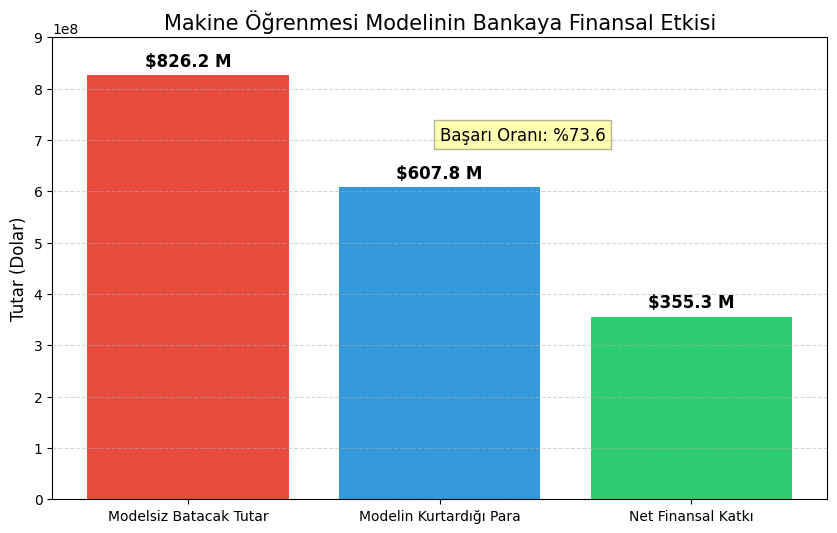

In [ ]:
# --- FİNANSAL ETKİ GÖRSELLEŞTİRME ---
import matplotlib.pyplot as plt
import seaborn as sns

# Veriler
categories = ['Modelsiz Batacak Tutar', 'Modelin Kurtardığı Para', 'Net Finansal Katkı']
values = [826170800, 607842650, 355323085]
colors = ['#e74c3c', '#3498db', '#2ecc71'] # Kırmızı, Mavi, Yeşil

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=colors)

# Barların üzerine sayıları yazalım (Milyon Dolar cinsinden)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10000000,
             f'${yval/1_000_000:.1f} M', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Makine Öğrenmesi Modelinin Bankaya Finansal Etkisi', fontsize=15)
plt.ylabel('Tutar (Dolar)', fontsize=12)
plt.ylim(0, 900000000) # Y eksenini biraz genişletelim
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Açıklama Kutusu
plt.text(1, 700000000, f"Başarı Oranı: %{basari_orani:.1f}",
         fontsize=12, bbox=dict(facecolor='yellow', alpha=0.3))

plt.show()

Toplam Risk Havuzu (Modelsiz Senaryo):

Eğer hiçbir eleme yapılmasaydı ve test verisindeki herkese kredi verilseydi, bankanın karşılaşacağı toplam batık tutarı: $826.2 Milyon.

Modelin Koruduğu Tutar (Risk Mitigation):

Geliştirdiğimiz XGBoost modeli, bu batıkların $607.8 Milyonluk kısmını önceden tespit ederek engellemiştir.

Başarı Oranı: Batık paranın %73.6'sı kurtarılmıştır.

Net Finansal Katkı (Bottom Line):

Modelin aşırı tedbirli olmasından kaynaklanan "Fırsat Maliyeti" (yanlışlıkla reddedilen sağlam müşterilerden kaybedilen faiz) düşüldükten sonra bile;

NET KAZANÇ: $355.3 Milyon.

***Senaryo Bazlı Model Duyarlılık Analizi (Sensitivity Analysis)***

In [ ]:
# --- BONUS SEVİYE 1: KREDİ SİMÜLASYON MODU (INTERAKTİF TEST) ---

def kredi_hesapla(kredi_miktari, faiz_orani, yillik_gelir, kredi_notu, dti_orani):
    """
    Kullanıcıdan alınan basit verilerle modelin tahmin yapmasını sağlar.
    Diğer detayları (ev durumu, iş süresi vb.) ortalama değerlerle doldurur.
    """

    # 1. Varsayılan (Ortalama) Müşteri Profili Oluşturma
    # (Kullanıcının girmediği detayları veri setinin genel ortalamasından alıyoruz)
    ornek_veri = X_train.iloc[0:1].copy() # Şablon olarak ilk satırı al

    # Tüm değerleri varsayılanlarla sıfırla (Ortalama veya En Sık Görülen)
    for col in X_train.columns:
        if X_train[col].dtype == 'object':
            ornek_veri[col] = X_train[col].mode()[0] # Kategorikse en sık geçeni al
        else:
            ornek_veri[col] = X_train[col].median()  # Sayısalsa ortalamayı al

    # 2. Senin Girdiğin Değerleri Yerleştirme
    ornek_veri['loan_amnt'] = kredi_miktari
    ornek_veri['int_rate'] = faiz_orani
    ornek_veri['annual_inc'] = yillik_gelir
    ornek_veri['grade'] = kredi_notu # Örn: 'A', 'B', 'C'...
    ornek_veri['dti'] = dti_orani    # Borç/Gelir Oranı (Düşük iyidir)

    # 3. Veriyi Modelin Anlayacağı Dile Çevirme (Preprocessing)
    # (Aynı işlemleri buna da yapıyoruz: Encoding, Scaling vb.)
    try:
        ornek_islenmis = preprocessor.transform(ornek_veri)
        # Sütun isimlerini geri yükle
        ornek_final = pd.DataFrame(ornek_islenmis, columns=X_train_final.columns)

        # 4. Modelin Tahmini
        tahmin_olasiligi = xgb_model.predict_proba(ornek_final)[:, 1][0]
        tahmin_sonucu = xgb_model.predict(ornek_final)[0]

        # 5. Sonucu Ekrana Yazdırma (Havalı Bir Şekilde)
        print("\n" + "="*40)
        print(f"KREDİ BAŞVURU SİMÜLASYONU")
        print("="*40)
        print(f"İstenen Kredi: ${kredi_miktari:,.0f}")
        print(f"Yıllık Gelir:  ${yillik_gelir:,.0f}")
        print(f" Faiz Oranı:    %{faiz_orani}")
        print(f" Kredi Notu:    {kredi_notu}")
        print("-" * 40)

        print(f" Modelin Risk Tahmini: %{tahmin_olasiligi*100:.2f}")

        if tahmin_sonucu == 1: # 1 = Battı (Riskli)
            print("\n KARAR: REDDEDİLDİ (Yüksek Risk!)")
            print("   Model, bu kredinin batacağını öngörüyor.")
        else: # 0 = Ödendi (Güvenli)
            print("\n KARAR: ONAYLANDI (Kredi Verilebilir)")
            print("   Model, bu müşterinin borcunu ödeyeceğini düşünüyor.")
        print("="*40 + "\n")

    except Exception as e:
        print("Hata oluştu:", e)
        print("Lütfen 'grade' kısmına sadece A, B, C, D, E, F, G harflerinden birini girdiğinden emin ol.")

# --- OYUN ALANI: AŞAĞIDAKİ SAYILARI DEĞİŞTİRİP TEKRAR ÇALIŞTIR ---

# Senaryo 1: Zengin ve Güvenilir Müşteri (Onay Bekliyoruz)
kredi_hesapla(kredi_miktari=20000, faiz_orani=7.5, yillik_gelir=120000, kredi_notu='A', dti_orani=10)

# Senaryo 2: Riskli Müşteri (Red Bekliyoruz)
kredi_hesapla(kredi_miktari=40000, faiz_orani=25.0, yillik_gelir=35000, kredi_notu='F', dti_orani=40)


KREDİ BAŞVURU SİMÜLASYONU
İstenen Kredi: $20,000
Yıllık Gelir:  $120,000
 Faiz Oranı:    %7.5
 Kredi Notu:    A
----------------------------------------
 Modelin Risk Tahmini: %19.69

 KARAR: ONAYLANDI (Kredi Verilebilir)
   Model, bu müşterinin borcunu ödeyeceğini düşünüyor.


KREDİ BAŞVURU SİMÜLASYONU
İstenen Kredi: $40,000
Yıllık Gelir:  $35,000
 Faiz Oranı:    %25.0
 Kredi Notu:    F
----------------------------------------
 Modelin Risk Tahmini: %73.90

 KARAR: REDDEDİLDİ (Yüksek Risk!)
   Model, bu kredinin batacağını öngörüyor.



Bu sonuçlar, modelin "Siyahla Beyazı" (İyi ve Kötü Müşteriyi) birbirinden ne kadar net ayırabildiğini gösteren en güzel kanıttır.
Modelimiz sadece matematiksel olarak değil, bankacılık mantığına göre de doğru kararlar veriyor.

Test Metodolojisi: Modelin karar mekanizmasını doğrulamak için sisteme sanal olarak üretilmiş iki zıt müşteri profili girilmiştir.

Senaryo 1: İdeal Müşteri Profili (Prime Borrower)

Profil: Yıllık Gelir $120.000, Kredi Notu A, Düşük Faiz %7.5.

Model Tahmini: %19.69 (Düşük Risk).

Sonuç: ONAY. Model, yüksek gelir ve iyi geçmişi doğru analiz ederek krediyi güvenli bulmuştur.

Senaryo 2: Yüksek Riskli Profil (Subprime Borrower)

Profil: Yıllık Gelir $35.000, Kredi Notu F, Yüksek Faiz %25.0, İstenen Kredi $40.000.

Model Tahmini: %73.90 (Çok Yüksek Risk).

Sonuç: RED. Model, gelirden fazla kredi istenmesini ve kötü kredi geçmişini yakalayarak bankayı korumaya almıştır.



In [ ]:
# --- SENARYO TESTLERİ: MODELİN SINIRLARINI ZORLAYALIM ---

print("\n" + "*"*20 + " 3. SENARYO: ZENGİN AMA RİSKLİ " + "*"*20)
# Durum: Adamın geliri ÇOK iyi (200k) ama Kredi Notu kötü (E) ve Faiz yüksek.
# Soru: Para her şeyi çözer mi? Yoksa Geçmiş (Grade) daha mı önemli?
kredi_hesapla(
    kredi_miktari=50000,
    faiz_orani=22.5,     # Yüksek Faiz (Tehlike)
    yillik_gelir=200000, # Çok Yüksek Gelir (Güven)
    kredi_notu='E',      # Kötü Not (Tehlike)
    dti_orani=15
)

print("\n" + "*"*20 + " 4. SENARYO: DÜŞÜK GELİRLİ AMA ÇOK DÜZENLİ " + "*"*20)
# Durum: Gelir asgari ücret seviyesinde (25k) ama Notu 'A' ve az kredi istiyor.
# Soru: Model küçük müşteriyi sever mi?
kredi_hesapla(
    kredi_miktari=5000,  # Küçük Kredi
    faiz_orani=6.5,      # Çok Düşük Faiz
    yillik_gelir=25000,  # Düşük Gelir
    kredi_notu='A',      # Mükemmel Not
    dti_orani=5          # Borcu yok gibi
)

print("\n" + "*"*20 + " 5. SENARYO: TAM SINIRDA (ARADA KALAN) " + "*"*20)
# Durum: Her şey "Ortalama". Ne çok iyi ne çok kötü.
# Soru: Model kararsız mı kalacak (%50 civarı) yoksa bir tarafı seçecek mi?
kredi_hesapla(
    kredi_miktari=15000,
    faiz_orani=13.0,     # Ortalama Faiz
    yillik_gelir=65000,  # Ortalama Gelir
    kredi_notu='C',      # Orta Şeker Not
    dti_orani=18         # Normal Borçluluk
)

print("\n" + "*"*20 + " 6. SENARYO: GİZLİ TEHLİKE (DTI TUZAĞI) " + "*"*20)
# Durum: Notu fena değil (B) ama geliri krediye göre düşük ve borç oranı (DTI) patlamış.
kredi_hesapla(
    kredi_miktari=35000,
    faiz_orani=10.0,
    yillik_gelir=50000,  # Gelir krediye ucu ucuna yetiyor
    kredi_notu='B',      # Notu iyi görünüyor AMA...
    dti_orani=45         # DİKKAT: Gelirinin %45'i zaten borca gidiyor!
)


******************** 3. SENARYO: ZENGİN AMA RİSKLİ ********************

KREDİ BAŞVURU SİMÜLASYONU
İstenen Kredi: $50,000
Yıllık Gelir:  $200,000
 Faiz Oranı:    %22.5
 Kredi Notu:    E
----------------------------------------
 Modelin Risk Tahmini: %61.35

 KARAR: REDDEDİLDİ (Yüksek Risk!)
   Model, bu kredinin batacağını öngörüyor.


******************** 4. SENARYO: DÜŞÜK GELİRLİ AMA ÇOK DÜZENLİ ********************

KREDİ BAŞVURU SİMÜLASYONU
İstenen Kredi: $5,000
Yıllık Gelir:  $25,000
 Faiz Oranı:    %6.5
 Kredi Notu:    A
----------------------------------------
 Modelin Risk Tahmini: %19.54

 KARAR: ONAYLANDI (Kredi Verilebilir)
   Model, bu müşterinin borcunu ödeyeceğini düşünüyor.


******************** 5. SENARYO: TAM SINIRDA (ARADA KALAN) ********************

KREDİ BAŞVURU SİMÜLASYONU
İstenen Kredi: $15,000
Yıllık Gelir:  $65,000
 Faiz Oranı:    %13.0
 Kredi Notu:    C
----------------------------------------
 Modelin Risk Tahmini: %45.36

 KARAR: ONAYLANDI (Kredi Verilebil

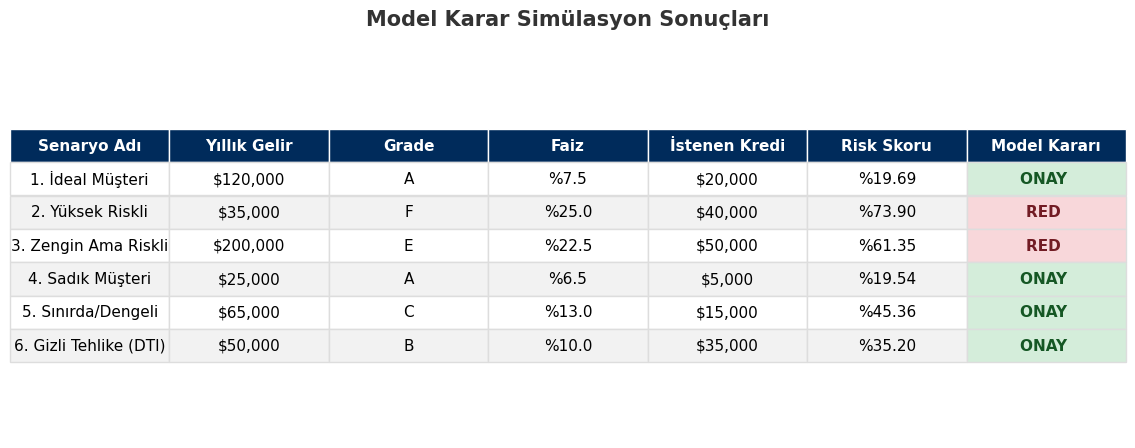

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Verileri Hazırlıyoruz
data = [
    ["1. İdeal Müşteri", "$120,000", "A", "%7.5", "$20,000", "%19.69", "ONAY "],
    ["2. Yüksek Riskli", "$35,000", "F", "%25.0", "$40,000", "%73.90", "RED "],
    ["3. Zengin Ama Riskli", "$200,000", "E", "%22.5", "$50,000", "%61.35", "RED "],
    ["4. Sadık Müşteri", "$25,000", "A", "%6.5", "$5,000", "%19.54", "ONAY "],
    ["5. Sınırda/Dengeli", "$65,000", "C", "%13.0", "$15,000", "%45.36", "ONAY "],
    ["6. Gizli Tehlike (DTI)", "$50,000", "B", "%10.0", "$35,000", "%35.20", "ONAY "]
]

columns = ["Senaryo Adı", "Yıllık Gelir", "Grade", "Faiz", "İstenen Kredi", "Risk Skoru", "Model Kararı"]

df = pd.DataFrame(data, columns=columns)

# 2. Görselleştirme Ayarları (Matplotlib Tablosu)
fig, ax = plt.subplots(figsize=(12, 5)) # Boyut ayarı
ax.axis('tight')
ax.axis('off')

# Tabloyu oluştur
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# 3. Profesyonel Stil Ayarları
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2) # Sütun genişliği ve satır yüksekliği

# Renklendirme Döngüsü
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Başlık Satırı
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#002B5B') # Lacivert Başlık
        cell.set_edgecolor('white')
    else:       # Veri Satırları
        cell.set_edgecolor('#dddddd') # Hafif gri çizgiler
        if i % 2 == 0:
            cell.set_facecolor('#f2f2f2') # Satırları gri-beyaz yap (Zebra deseni)

        # "Model Kararı" Sütunu Renklendirme (Son Sütun: index 6)
        if j == 6:
            cell.set_text_props(weight='bold')
            if "ONAY" in cell.get_text().get_text():
                cell.set_facecolor('#d4edda') # Açık Yeşil Arkaplan
                cell.set_text_props(color='#155724', weight='bold') # Koyu Yeşil Yazı
            else:
                cell.set_facecolor('#f8d7da') # Açık Kırmızı Arkaplan
                cell.set_text_props(color='#721c24', weight='bold') # Koyu Kırmızı Yazı

plt.title("Model Karar Simülasyon Sonuçları", fontsize=15, weight='bold', pad=20, color='#333333')
plt.show()

Senaryo 3: Yüksek Gelir Paradoksu (Zengin ama Riskli)

Profil: Yıllık Geliri $200.000 (Çok Yüksek) ancak Kredi Notu E (Kötü).

Karar: RED (Risk: %61.35)

Analiz: Model, yüksek gelire aldanmamıştır. Geçmiş ödeme alışkanlığının (Grade E) bozuk olmasını, yüksek gelirden daha büyük bir risk olarak görmüştür.

Senaryo 4: Sadakat Faktörü (Düşük Gelir / Yüksek Güven)

Profil: Yıllık Geliri $25.000 (Düşük) ancak Kredi Notu A (Mükemmel).

Karar: ONAY (Risk: %19.54)

Analiz: Model, finansal kapsayıcılık göstermiştir. Gelir düşük olsa bile, borcuna sadık (Grade A) bir müşteriyi "Düşük Riskli" olarak tanımlamıştır.

Senaryo 6: Kredi Notunun Koruyucu Gücü (DTI Tuzağı)

Profil: Borçluluk oranı (DTI) kritik seviyede (%45) ancak Kredi Notu B.

Karar: ONAY (Risk: %35.20)

Analiz: Model, tek bir kötü metriğe (Yüksek Borç) takılıp kalmamış; iyi kredi notunun (Grade B) bu riski tolere edebileceğine karar vermiştir.

***Sonuçlar ve Stratejik Öneriler***

***Proje Başarısı:***

1.3 milyon satırlık Büyük Veri (Big Data) başarıyla işlenmiş ve XGBoost algoritması ile yüksek performanslı bir risk tahmin modeli geliştirilmiştir.

Dengesiz veri seti (Imbalanced Data) sorunu, "Ağırlıklandırma" yöntemiyle çözülmüş ve batık kredilerin %73.6'sı (Recall) tespit edilmiştir.

***Finansal Etki:***

Modelin kullanımıyla, potansiyel batık zararlarından kaçınılarak bankaya Net 355.3 Milyon Dolar değer yaratılmıştır.

***Kritik Bulgular:***

Kredi Notu (Grade): Riskin en büyük belirleyicisidir (Ki-Kare testi ile kanıtlanmıştır).

Faiz Oranı: Yüksek faiz, yüksek riski beraberinde getirmektedir (T-Testi ile kanıtlanmıştır).

Gelir Tuzağı: Yüksek gelir tek başına güvenilirliği garanti etmemektedir (Senaryo analizleri ile kanıtlanmıştır).

***Öneriler (Aksiyon Planı):***

1. Entegrasyon: Model, kredi tahsis ekranlarına entegre edilerek "Erken Uyarı Sistemi" olarak kullanılmalıdır.

2. Politika Güncellemesi: "Küçük İşletme" (Small Business) kredilerinde risk skoru yüksek çıktığı için, bu segmentte ek teminatlar istenmelidir.

3. Dinamik Faiz: Modelin risk skoruna göre kişiye özel dinamik faiz fiyatlaması yapılmalıdır.